In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy as sp
import math

In [2]:
players = pd.read_pickle('players.pkl')
results = pd.read_pickle('results.pkl')
tournaments = pd.read_pickle('tournaments.pkl')

### Подсчет сложности турнира как средней сложности вопросов (колонка questionQty)

In [19]:
tournament_number_of_questions = {}
tournament_complexity_2019 = {}
tournament_complexity_2019_no_zeros = {}
tournament_complexity_2020 = {}
tournament_complexity_2020_no_zeros = {}
tournament_name_by_tournament_id = {}
for tournament in tournaments.values():
    questionQty = tournament['questionQty']
    name = tournament['questionQty']
    tournament_name_by_tournament_id[tournament['id']] = tournament['name']
    res = 0
    num_of_questions = 0
    if questionQty is not None:
        for complexity, num_of_questions_with_complexity in questionQty.items():
            res += int(complexity) * num_of_questions_with_complexity
            num_of_questions += num_of_questions_with_complexity
    if tournament['dateStart'] >= '2019-01-01' and tournament['dateStart'] < '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2019[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2019[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2019_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
    elif tournament['dateStart'] >= '2020-01-01':
        if num_of_questions != 0:
            tournament_complexity_2020[tournament['id']] = res/num_of_questions
        else:
            tournament_complexity_2020[tournament['id']] = 0
        if res != 0:
            tournament_complexity_2020_no_zeros[tournament['id']] = res/num_of_questions
        tournament_number_of_questions[tournament['id']] = num_of_questions
            
print(len(tournament_complexity_2019))
print(len(tournament_complexity_2019_no_zeros))
print(len(tournament_complexity_2020))
print(len(tournament_complexity_2020_no_zeros))
print(len(tournament_number_of_questions))

tournament_complexity = tournament_complexity_2019
tournament_complexity.update(tournament_complexity_2020)

687
687
422
422
1109


### Подсчет сложности вопросов как процента неправильных ответов и оценка рейтинга игроков 

In [24]:
tournament_ids_with_mask_number_of_questions_inconsistency = set()

player_real_rating_by_the_beginning_of_2019 = {}
player_real_rating_by_the_end_of_2019 = {}
player_estimated_rating_increase_in_2019 = {}

player_real_rating_by_the_beginning_of_2020 = {}
player_real_rating_by_the_end_of_2020 = {}
player_estimated_rating_increase_in_2020 = {}

team_player_ids_2019 = {}
team_player_ids_2020 = {}
percent_answered_by_team = {}
team_ids_by_tournament_id_2020 = {}

tournament_complexity_by_name = {}

team_id = 1
for tournament_id, tournament_result in results.items():
    if tournament_id in tournament_number_of_questions:
        tournament_masks = []
        for team_result in tournament_result:
            if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                team_mask = []
                for i in range(tournament_number_of_questions[tournament_id]):
                    question_result = team_result['mask'][i]
                    if question_result == '0' or question_result == '1':
                        team_mask.append(float(question_result))
                    else:
                        team_mask.append(0.5)
                tournament_masks.append(team_mask)
        if len(tournament_masks) == 0:
            tournament_ids_with_mask_number_of_questions_inconsistency.add(tournament_id)
        else:
            tournament_question_complexity = 1 - np.mean(np.array(tournament_masks), axis=0)
            tournament_complexity_by_name[tournament_name_by_tournament_id[tournament_id]] = tournament_complexity[tournament_id] * np.mean(tournament_question_complexity)
            for team_result in tournament_result:
                if len(team_result['teamMembers']) > 0 and 'mask' in team_result and team_result['mask'] != None and len(team_result['mask']) >= tournament_number_of_questions[tournament_id]:
                    team_mask = []
                    for i in range(tournament_number_of_questions[tournament_id]):
                        question_result = team_result['mask'][i]
                        if question_result == '0' or question_result == '1':
                            team_mask.append(float(question_result))
                        else:
                            team_mask.append(0.5)
                    percent_answered_by_team[team_id] = np.sum(np.array(team_mask)) / len(team_mask)
                    estimated_rating_increase = tournament_complexity[tournament_id] * np.dot(tournament_question_complexity, team_mask)
                    player_ids = []
                    for player in team_result['teamMembers']:
                        player_id = player['player']['id']
                        player_rating = player['rating']
                        player_ids.append(player_id)
                        if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                            if player_id not in player_real_rating_by_the_beginning_of_2019:
                                player_real_rating_by_the_beginning_of_2019[player_id] = player_rating
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2019[player_id] = player_rating
                                player_estimated_rating_increase_in_2019[player_id] += estimated_rating_increase
                        else:
                            if player_id not in player_real_rating_by_the_beginning_of_2020:
                                player_real_rating_by_the_beginning_of_2020[player_id] = player_rating
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] = estimated_rating_increase
                            else:
                                player_real_rating_by_the_end_of_2020[player_id] = player_rating
                                player_estimated_rating_increase_in_2020[player_id] += estimated_rating_increase
                    if tournaments[tournament_id]['dateStart'] < '2020-01-01':
                        team_player_ids_2019[team_id] = player_ids
                    else:
                        team_player_ids_2020[team_id] = player_ids
                        if tournament_id in team_ids_by_tournament_id_2020:
                            team_ids_by_tournament_id_2020[tournament_id].append(team_id)
                        else:
                            team_ids_by_tournament_id_2020[tournament_id] = [team_id]
                    team_id += 1
                        
print(len(tournament_ids_with_mask_number_of_questions_inconsistency))

262


### Baseline-модель, обучающая рейтинг-лист игроков

57429
57429
30409
30409
0.3891916126362257


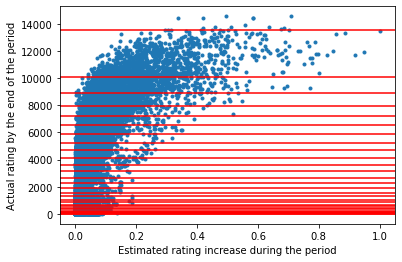

In [5]:
def get_category_upper_borders(array, num_of_categories):
    array_sorted = np.sort(array)
    category_size = int(len(array_sorted) / num_of_categories)
    category_upper_borders = []
    for i in range(num_of_categories):
        category_upper_border_index = (i + 1) * category_size - 1
        category_upper_borders.append(array_sorted[category_upper_border_index])
    return category_upper_borders

def get_category(element, category_upper_borders):
    num_of_categories = len(category_upper_borders)
    for i in range(num_of_categories):
        if element <= category_upper_borders[i]:
            return i
    return num_of_categories - 1

x_train = np.array(list(player_estimated_rating_increase_in_2019.values()))
print(len(x_train))
y_train = np.array(list(player_real_rating_by_the_end_of_2019.values()))
print(len(y_train))
x_train = x_train[y_train != 0]
print(len(x_train))
y_train = y_train[y_train != 0]
print(len(y_train))
x_train = np.interp(x_train, (x_train.min(), x_train.max()), (0, 1))
plt.scatter(x_train, y_train, marker='.')
plt.xlabel("Estimated rating increase during the period")
plt.ylabel("Actual rating by the end of the period")
category_upper_borders = get_category_upper_borders(y_train, 30)
y_train = np.array([get_category(y, category_upper_borders) for y in y_train])
for border in category_upper_borders:
    plt.axhline(y=border, color='red')
    
clf = LogisticRegression(random_state=0).fit(x_train.reshape(-1, 1), y_train)

x_test = np.array(list(player_estimated_rating_increase_in_2020.values()))
x_test = np.interp(x_test, (x_test.min(), x_test.max()), (0, 1))
y_test = np.array(list(player_real_rating_by_the_end_of_2020.values()))
y_test = np.array([get_category(y, category_upper_borders) for y in y_test])

score = clf.score(x_test.reshape(-1, 1), y_test)
print(score)

### Кластеризация по максимальному рейтингу игрока в команде

In [6]:
def e_step(xs, pis, mus, sigmas):
    k = mus.shape[0]
    z = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    print(mus[0])
    print(sp.stats.multivariate_normal.pdf(xs, mean=mus[0], cov=sigmas[0]))
    ## здесь z_{nk} = p(C_k)p(x_n|C_k)
    z = np.divide( z, np.sum(z, axis=0) ).T
    ## z_{nk} = p(C_k|x_n)
    return z

def m_step(xs, z):
    k = z.shape[1]
    pis = np.sum(z, axis=0) / np.sum(z)
    mus = np.array([np.average(xs, weights=z[:,i], axis=0) for i in range(k)])
    sigmas = np.array([np.cov(xs.T, aweights=z[:,i]) for i in range(k)])
    return pis, mus, sigmas

def loglikelihood(xs, pis, mus, sigmas):
    k = mus.shape[0]
    return np.sum(np.log(np.sum(np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ]), axis=0)))

In [7]:
def normalize(x):
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    return (x - x_min) / (x_max - x_min)

In [8]:
team_results = []
for team_id, player_ids in team_player_ids_2019.items():
    team_player_ratings = []
    for i in range(len(player_ids)):
        if player_ids[i] in player_estimated_rating_increase_in_2019:
            team_player_ratings.append(player_estimated_rating_increase_in_2019[player_ids[i]])
    team_results.append(-np.sort(-np.array(team_player_ratings)))

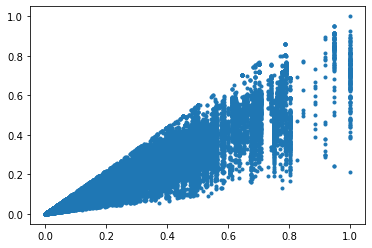

In [9]:
x_train = []
for team_result in team_results:
    x_train.append([team_result[0], np.mean(team_result)])
x_train = normalize(np.array(x_train))
plt.scatter(x_train[:, 0], x_train[:, 1], marker='.')

In [10]:
def em(x, k):
    mus = x[np.random.choice(x.shape[0], size=k, replace=False), : ]
    sigmas = np.array( [ 1 for _ in range(k) ] )
    pis = (1./k) * np.ones(k)
    z = e_step( x, pis, mus, sigmas)
    
    ## EM-алгоритм
    old_logl, new_logl = -np.inf, -np.inf
    for iIter in range(5000):
        old_logl = new_logl
        z = e_step( x, pis, mus, sigmas)
        print(z)
        new_pis, new_mus, new_sigmas = m_step(x, z)
        pis, mus, sigmas = new_pis, new_mus, new_sigmas
        new_logl = loglikelihood(x, pis, mus, sigmas)
        print("Логарифм правдоподобия на итерации %03d: %.6f" % (iIter, new_logl) )
        if np.abs(new_logl - old_logl) < 0.01:
            break

    print("После %d итераций правдоподобие = %.6f" % (iIter, new_logl) )
    
    pis_mus_sigmas = np.concatenate((pis.reshape((-1, 1)), mus.reshape((-1, 1)), sigmas.reshape((-1, 1))), axis=1)
    pis_mus_sigmas = pis_mus_sigmas[np.argsort(pis_mus_sigmas[:, 1])]
    
    pis = pis_mus_sigmas[:, 0]
    mus = pis_mus_sigmas[:, 1]
    sigmas = pis_mus_sigmas[:, 2]
    
    if len(x[0, :] == 1):
        plt.scatter(x, np.zeros(len(x)), marker='.')
        for i in range(k):
            t = np.linspace(0, 2*np.pi, 100)
            r = np.sqrt(sigmas[i])
            circle = plt.plot(mus[i] + r*np.cos(t) , r*np.sin(t))
            mu = plt.scatter(mus[i], 0, marker='.', color=circle[0].get_color(), label=f'Cluster: {i}')
        plt.legend()
        plt.xlabel("Maximal player rating in team")
    
    return pis, mus, sigmas

[0.13178374]
[0.36439122 0.39558817 0.39734372 ... 0.39625984 0.39610324 0.39576074]
[0.13178374]
[0.36439122 0.39558817 0.39734372 ... 0.39625984 0.39610324 0.39576074]
[[0.138902   0.14649772 0.14983515 ... 0.15171882 0.13576285 0.13518719]
 [0.14406295 0.14524799 0.14418015 ... 0.13597431 0.14293348 0.14269989]
 [0.14474866 0.14504529 0.14339281 ... 0.13392674 0.14390772 0.14372377]
 ...
 [0.14817557 0.14389686 0.13932769 ... 0.12384909 0.14885922 0.14893958]
 [0.14823043 0.14387659 0.13926082 ... 0.12368986 0.14893966 0.14902447]
 [0.14834533 0.14383396 0.1391206  ... 0.12335662 0.14910823 0.14920241]]
Логарифм правдоподобия на итерации 000: 18541.624526
[0.1873311]
[0.31050182 1.95305308 2.07633188 ... 1.39701469 1.37446399 1.32701233]
[[0.13302843 0.14799163 0.15635784 ... 0.16950051 0.12757849 0.12660987]
 [0.14597681 0.14470294 0.14200009 ... 0.13024355 0.14563708 0.14553882]
 [0.14686557 0.14436693 0.14090953 ... 0.12767242 0.14694499 0.14691996]
 ...
 [0.14848725 0.14373066 0

[0.10895871]
[3.65812821e-12 2.52466855e-01 1.13336045e+00 ... 1.96779473e+00
 1.79937080e+00 1.47643606e+00]
[[1.21192422e-12 2.55261061e-02 1.79225868e-01 ... 7.95246895e-01
  3.71532712e-37 9.04273534e-56]
 [2.63225815e-02 3.31968426e-01 2.92594834e-01 ... 1.40969600e-01
  4.12660996e-07 8.63875203e-11]
 [1.02076572e-01 2.75244397e-01 2.07849978e-01 ... 9.51667818e-02
  6.11666372e-05 1.88270105e-07]
 ...
 [6.65090255e-02 1.07885351e-02 5.98359322e-03 ... 5.41496181e-03
  3.46791501e-01 5.42249670e-01]
 [6.55965377e-02 1.09017863e-02 6.05619746e-03 ... 5.61460038e-03
  3.47573476e-01 5.42342872e-01]
 [6.48616222e-02 1.14249735e-02 6.37281466e-03 ... 6.22326932e-03
  3.50607599e-01 5.38851404e-01]]
Логарифм правдоподобия на итерации 016: 45095.187849
[0.11273912]
[4.07175490e-13 2.28880485e-01 1.13545700e+00 ... 1.63718522e+00
 1.47822026e+00 1.17996663e+00]
[[1.38462311e-13 2.48495490e-02 1.77606130e-01 ... 7.97544036e-01
  3.53546325e-40 2.76185903e-68]
 [2.47085673e-02 3.35819235e

[0.1160198]
[2.27278794e-24 1.99482391e-02 3.80158658e-01 ... 5.12200048e-01
 4.19652901e-01 2.70545955e-01]
[[1.00382972e-024 2.08755584e-002 1.84037634e-001 ... 7.95086807e-001
  8.31702017e-092 0.00000000e+000]
 [2.89817048e-003 3.79036440e-001 3.32267133e-001 ... 1.06693107e-001
  1.14039959e-015 2.24372420e-110]
 [4.82288741e-002 2.92758357e-001 2.11408039e-001 ... 6.84398243e-002
  2.86880617e-010 1.91482847e-077]
 ...
 [1.01754299e-002 2.00692334e-003 8.47153011e-004 ... 1.10848869e-003
  7.12871390e-002 9.08951226e-001]
 [8.40260749e-003 1.85668085e-003 7.81783867e-004 ... 1.06634138e-003
  5.59829998e-002 9.26950664e-001]
 [7.25913465e-003 2.07159405e-003 8.68300283e-004 ... 1.29462164e-003
  4.17958343e-002 9.41738409e-001]]
Логарифм правдоподобия на итерации 030: 50594.882503
[0.1161751]
[1.13237464e-24 1.87644215e-02 3.70320432e-01 ... 4.91548430e-01
 4.01558229e-01 2.57228787e-01]
[[5.04085633e-025 2.05516325e-002 1.86971280e-001 ... 7.92477086e-001
  1.27630979e-095 0.000

[0.11521091]
[2.11358677e-29 5.79549110e-03 2.04654417e-01 ... 3.28958790e-01
 2.59402735e-01 1.53685423e-01]
[[1.04318393e-029 1.75178140e-002 2.20871462e-001 ... 7.61610723e-001
  8.86937787e-122 0.00000000e+000]
 [9.25657501e-004 3.81210530e-001 3.20306804e-001 ... 8.56490140e-002
  9.21829051e-022 3.38165360e-246]
 [2.88196431e-002 2.91940449e-001 1.96148215e-001 ... 5.39227325e-002
  1.81211257e-014 9.20368708e-174]
 ...
 [7.74909785e-003 1.64671699e-003 6.09742319e-004 ... 7.88105790e-004
  1.58550712e-001 8.25825857e-001]
 [5.02382102e-003 1.23453500e-003 4.56132006e-004 ... 6.16522368e-004
  1.02216440e-001 8.87001025e-001]
 [3.40431267e-003 1.15927062e-003 4.26719347e-004 ... 6.34729662e-004
  6.48991632e-002 9.26562278e-001]]
Логарифм правдоподобия на итерации 041: 51663.215683
[0.11486245]
[7.90936135e-30 5.10718890e-03 1.90703820e-01 ... 3.24482177e-01
 2.55302851e-01 1.50501734e-01]
[[3.94690916e-030 1.71987711e-002 2.24492810e-001 ... 7.58308417e-001
  2.96855145e-124 0.0

[0.10934623]
[4.91683347e-32 1.97407230e-03 1.03178778e-01 ... 4.17873353e-01
 3.29568257e-01 1.95016476e-01]
[[2.76842406e-032 1.39624930e-002 2.63311511e-001 ... 7.22725992e-001
  4.12034831e-153 0.00000000e+000]
 [3.51553619e-004 3.72209226e-001 2.98368050e-001 ... 6.84231464e-002
  2.23601189e-028 0.00000000e+000]
 [1.60854932e-002 2.83420120e-001 1.72420316e-001 ... 4.16670803e-002
  4.11093146e-019 0.00000000e+000]
 ...
 [1.76067084e-002 2.33063880e-003 6.19175397e-004 ... 8.42416127e-004
  4.05217681e-001 5.67200909e-001]
 [8.57787810e-003 1.30864538e-003 3.45761885e-004 ... 4.93755800e-004
  1.99270827e-001 7.86701701e-001]
 [3.84606642e-003 8.08533393e-004 2.11358269e-004 ... 3.34760721e-004
  8.50222224e-002 9.07952001e-001]]
Логарифм правдоподобия на итерации 053: 52302.768846
[0.10877929]
[4.72270410e-32 1.88181953e-03 9.92481779e-02 ... 4.36991311e-01
 3.45295661e-01 2.05141923e-01]
[[2.68782780e-032 1.36812532e-002 2.66556433e-001 ... 7.19762309e-001
  6.32665705e-156 0.0

[0.10287622]
[1.14267209e-31 1.32711327e-03 7.14447232e-02 ... 7.06955290e-01
 5.71589214e-01 3.56693536e-01]
[[7.25381357e-032 1.03391664e-002 2.97660765e-001 ... 6.92000064e-001
  8.37953926e-189 0.00000000e+000]
 [2.62424653e-004 3.65300342e-001 2.76341268e-001 ... 5.53849224e-002
  9.26492867e-036 0.00000000e+000]
 [1.20972797e-002 2.73773178e-001 1.46047072e-001 ... 3.20964954e-002
  2.80707253e-024 0.00000000e+000]
 ...
 [4.41389358e-002 2.78881208e-003 4.33877128e-004 ... 7.50728874e-004
  6.65892870e-001 2.79178597e-001]
 [2.16806297e-002 1.53485877e-003 2.35829798e-004 ... 4.31428377e-004
  3.22684553e-001 6.49878752e-001]
 [7.01889990e-003 6.44599030e-004 9.65625587e-005 ... 1.98989423e-004
  9.27544205e-002 8.97961854e-001]]
Логарифм правдоподобия на итерации 065: 52583.866690
[0.10239142]
[1.25375128e-31 1.29328849e-03 6.96441349e-02 ... 7.33966218e-01
 5.94544618e-01 3.72516306e-01]
[[8.02937122e-032 1.00072014e-002 3.00090764e-001 ... 6.89902030e-001
  6.46766274e-192 0.0

Логарифм правдоподобия на итерации 075: 52724.919170
[0.09810325]
[1.79144753e-31 9.77295646e-04 5.40265941e-02 ... 9.93297553e-01
 8.16714126e-01 5.28303464e-01]
[[1.23710171e-031 6.59121264e-003 3.21387121e-001 ... 6.72021662e-001
  3.51827272e-223 0.00000000e+000]
 [2.07448870e-004 3.67757198e-001 2.54605028e-001 ... 4.55659908e-002
  7.50767844e-043 0.00000000e+000]
 [9.62061382e-003 2.72068296e-001 1.22405761e-001 ... 2.51448014e-002
  3.07619565e-029 0.00000000e+000]
 ...
 [7.10043308e-002 2.53853671e-003 2.21389907e-004 ... 5.38288417e-004
  8.01441999e-001 1.17667040e-001]
 [4.09252093e-002 1.60286034e-003 1.37154969e-004 ... 3.55793782e-004
  4.47777543e-001 5.05256951e-001]
 [1.05353463e-002 5.10052195e-004 4.19728943e-005 ... 1.25033519e-004
  9.66575995e-002 8.91013849e-001]]
Логарифм правдоподобия на итерации 076: 52736.128869
[0.09772762]
[1.74485975e-31 9.47134546e-04 5.26398918e-02 ... 1.01721131e+00
 8.37316908e-01 5.42925489e-01]
[[1.21250479e-031 6.25732266e-003 3.23

[0.09412295]
[6.95112084e-32 6.44515545e-04 3.91068084e-02 ... 1.24938028e+00
 1.03768062e+00 6.85651342e-01]
[[5.10568350e-032 3.08254174e-003 3.40835877e-001 ... 6.56081578e-001
  2.00276125e-258 0.00000000e+000]
 [1.43155931e-004 3.84227866e-001 2.29203140e-001 ... 3.65569496e-002
  3.76068346e-050 0.00000000e+000]
 [7.13933584e-003 2.81580224e-001 9.86594521e-002 ... 1.90979010e-002
  2.36313135e-034 0.00000000e+000]
 ...
 [9.07122506e-002 1.88865528e-003 8.59460643e-005 ... 3.27757022e-004
  8.61056137e-001 3.95894805e-002]
 [6.40462357e-002 1.43110003e-003 6.35834146e-005 ... 2.61673351e-004
  5.83668972e-001 3.45937234e-001]
 [1.37539307e-002 3.63654796e-004 1.53810560e-005 ... 7.44749734e-005
  1.00947258e-001 8.83790098e-001]]
Логарифм правдоподобия на итерации 088: 52842.033126
[0.09383666]
[6.09016569e-32 6.20332418e-04 3.80268816e-02 ... 1.26775181e+00
 1.05353000e+00 6.96933164e-01]
[[4.49097825e-032 2.85581560e-003 3.42194441e-001 ... 6.54949740e-001
  3.84376128e-261 0.0

[9.39315532e-33 3.94500559e-04 2.76130895e-02 ... 1.44398862e+00
 1.20503924e+00 8.03949093e-01]
[[7.16260203e-033 1.12426355e-003 3.55160417e-001 ... 6.43715317e-001
  3.19288902e-288 0.00000000e+000]
 [8.93054134e-005 4.17304462e-001 2.05369518e-001 ... 2.90102748e-002
  2.34557147e-056 0.00000000e+000]
 [5.05251694e-003 3.03299254e-001 7.95402258e-002 ... 1.43545552e-002
  1.04229555e-038 0.00000000e+000]
 ...
 [1.00834675e-001 1.19497637e-003 3.24309761e-005 ... 1.87231674e-004
  8.77952553e-001 1.32938600e-002]
 [8.28068650e-002 1.03216819e-003 2.73504334e-005 ... 1.72284577e-004
  6.90374843e-001 2.20134958e-001]
 [1.60921205e-002 2.27428790e-004 5.73953914e-006 ... 4.35424441e-005
  1.05687558e-001 8.76821322e-001]]
Логарифм правдоподобия на итерации 100: 52910.425160
[0.09079458]
[7.64892862e-33 3.77411400e-04 2.67847056e-02 ... 1.45793187e+00
 1.21695651e+00 8.12257664e-01]
[[5.84547713e-033 1.02802897e-003 3.56218375e-001 ... 6.42753594e-001
  2.00520147e-290 0.00000000e+000]

[5.07664121e-34 2.19797384e-04 1.86109889e-02 ... 1.59417431e+00
 1.33227259e+00 8.90882943e-01]
[[3.93962267e-034 3.88618978e-004 3.67992285e-001 ... 6.31619095e-001
  4.83797957e-312 0.00000000e+000]
 [4.98486201e-005 4.66779300e-001 1.87372724e-001 ... 2.28667363e-002
  2.47855049e-061 0.00000000e+000]
 [3.37079253e-003 3.33390915e-001 6.67903164e-002 ... 1.07435903e-002
  3.32364158e-042 0.00000000e+000]
 ...
 [1.05695210e-001 6.54974763e-004 1.47691764e-005 ... 1.04926332e-004
  8.81357585e-001 5.26808494e-003]
 [9.45204817e-002 6.03404728e-004 1.33802816e-005 ... 1.04501490e-004
  7.55534097e-001 1.42938079e-001]
 [1.76806902e-002 1.22497452e-004 2.62776318e-006 ... 2.51157187e-005
  1.10168886e-001 8.70760593e-001]]
Логарифм правдоподобия на итерации 112: 52959.047562
[0.08819878]
[3.76911060e-34 2.07825490e-04 1.79335462e-02 ... 1.60532228e+00
 1.34157653e+00 8.97018894e-01]
[[2.92655500e-034 3.56442086e-004 3.69146073e-001 ... 6.30497484e-001
  8.48288978e-314 0.00000000e+000]

[0.08577798]
[5.53919650e-36 9.71984085e-05 1.09170009e-02 ... 1.72122877e+00
 1.43620109e+00 9.56083041e-01]
[[4.28471333e-36 1.32177143e-04 3.83541359e-01 ... 6.16326464e-01
  0.00000000e+00 0.00000000e+00]
 [2.18216050e-05 5.36792020e-01 1.75083552e-01 ... 1.80492247e-02
  2.03830470e-65 0.00000000e+00]
 [1.94805900e-03 3.70601044e-01 5.91630903e-02 ... 8.10778349e-03
  4.50476000e-45 0.00000000e+00]
 ...
 [1.07979987e-01 2.89333199e-04 8.60901180e-06 ... 5.92051628e-05
  8.82074507e-01 2.63634389e-03]
 [1.00685021e-01 2.71615571e-04 8.08047701e-06 ... 6.12890935e-05
  7.91249330e-01 1.01161276e-01]
 [1.86300368e-02 5.19867793e-05 1.55043419e-06 ... 1.44914525e-05
  1.13859219e-01 8.66176689e-01]]
Логарифм правдоподобия на итерации 124: 53011.851761
[0.08553699]
[3.35201873e-36 8.90244220e-05 1.03138213e-02 ... 1.73154608e+00
 1.44438073e+00 9.60797519e-01]
[[2.58960176e-36 1.19374350e-04 3.85006343e-01 ... 6.14874282e-01
  0.00000000e+00 0.00000000e+00]
 [1.99571258e-05 5.43948774e

[0.08237498]
[1.16244425e-39 2.27204614e-05 4.28604281e-03 ... 1.85008564e+00
 1.53406689e+00 1.00551501e+00]
[[8.76871434e-40 2.66614093e-05 4.01967888e-01 ... 5.98005450e-01
  0.00000000e+00 0.00000000e+00]
 [4.95290047e-06 6.41401666e-01 1.61543723e-01 ... 1.41539778e-02
  2.34484785e-69 0.00000000e+00]
 [7.57934764e-04 4.25438774e-01 5.31650021e-02 ... 6.22994823e-03
  7.95552056e-48 0.00000000e+00]
 ...
 [1.08694917e-01 7.41362061e-05 5.14670383e-06 ... 3.33527855e-05
  8.83849038e-01 1.59143347e-03]
 [1.03190935e-01 6.85613090e-05 4.91346769e-06 ... 3.52060335e-05
  8.13406637e-01 7.78483769e-02]
 [1.89286746e-02 1.21492381e-05 9.34710194e-07 ... 8.29729490e-06
  1.16924207e-01 8.63116976e-01]]
Логарифм правдоподобия на итерации 136: 53111.167403
[0.08202351]
[4.07975643e-40 1.90272170e-05 3.82547277e-03 ... 1.86154055e+00
 1.54219466e+00 1.00866358e+00]
[[3.06833790e-40 2.20851398e-05 4.03480004e-01 ... 5.96497911e-01
  0.00000000e+00 0.00000000e+00]
 [4.13066087e-06 6.52088758e

Логарифм правдоподобия на итерации 147: 53304.608369
[0.07723767]
[5.33534559e-48 8.99382126e-07 5.42617725e-04 ... 1.98199806e+00
 1.61451842e+00 1.01401332e+00]
[[3.87725193e-48 1.13085511e-06 4.15831452e-01 ... 5.84167417e-01
  0.00000000e+00 0.00000000e+00]
 [1.80784655e-07 7.79375787e-01 1.35666448e-01 ... 1.05599496e-02
  1.15144520e-74 0.00000000e+00]
 [9.86194676e-05 5.27058702e-01 4.57409561e-02 ... 4.95607465e-03
  1.67446987e-51 0.00000000e+00]
 ...
 [1.06871704e-01 6.59903694e-06 2.04108514e-06 ... 1.79672727e-05
  8.89290229e-01 1.04108806e-03]
 [1.01459702e-01 5.79396990e-06 1.95595691e-06 ... 1.92050571e-05
  8.33899678e-01 6.20857940e-02]
 [1.81021959e-02 8.97877724e-07 3.66672450e-07 ... 4.54425714e-06
  1.20179644e-01 8.61290488e-01]]
Логарифм правдоподобия на итерации 148: 53327.488934
[0.07673687]
[4.83608442e-49 6.01494184e-07 4.19457967e-04 ... 1.99022884e+00
 1.61742100e+00 1.01015341e+00]
[[3.50582981e-49 7.95674612e-07 4.16289471e-01 ... 5.83709733e-01
  0.0000

Логарифм правдоподобия на итерации 159: 53543.393008
[0.07178077]
[4.69352473e-62 3.86545428e-09 1.64082142e-05 ... 2.03581036e+00
 1.60682755e+00 9.35860947e-01]
[[3.37712034e-62 2.00440556e-08 4.13309598e-01 ... 5.86690382e-01
  0.00000000e+00 0.00000000e+00]
 [6.85836398e-10 8.67200176e-01 1.09025703e-01 ... 7.59887525e-03
  1.26688097e-83 0.00000000e+00]
 [3.16575428e-06 6.85313964e-01 3.99747177e-02 ... 4.10558410e-03
  1.03477093e-57 0.00000000e+00]
 ...
 [1.00508304e-01 6.56553833e-07 6.64247782e-07 ... 9.74929274e-06
  8.98095770e-01 6.24873234e-04]
 [9.40872645e-02 5.46428625e-07 6.36099092e-07 ... 1.05499714e-05
  8.58343557e-01 4.69089163e-02]
 [1.60349137e-02 7.49142185e-08 1.18172640e-07 ... 2.54321460e-06
  1.24749794e-01 8.59119877e-01]]
Логарифм правдоподобия на итерации 160: 53555.287829
[0.07143731]
[4.38323150e-63 2.57660645e-09 1.26221467e-05 ... 2.04042056e+00
 1.60701354e+00 9.31141630e-01]
[[3.15579432e-63 1.59261032e-08 4.12764607e-01 ... 5.87235377e-01
  0.0000

[5.57616351e-70 1.55754625e-10 2.00782345e-06 ... 2.14645347e+00
 1.67134575e+00 9.41386803e-01]
[[4.03248540e-70 5.57894863e-09 4.11944119e-01 ... 5.88055875e-01
  0.00000000e+00 0.00000000e+00]
 [2.63496567e-11 8.78725382e-01 1.08641521e-01 ... 6.43368979e-03
  1.97540612e-92 0.00000000e+00]
 [3.85976304e-07 7.75028338e-01 4.13928169e-02 ... 3.54823949e-03
  7.04580372e-64 0.00000000e+00]
 ...
 [1.00212237e-01 6.35360961e-07 6.04891281e-07 ... 6.89722610e-06
  8.98994753e-01 3.37786083e-04]
 [9.36894133e-02 5.31171485e-07 5.85293340e-07 ... 7.53463920e-06
  8.72685655e-01 3.32444508e-02]
 [1.60249039e-02 7.43055700e-08 1.12386211e-07 ... 1.87383927e-06
  1.29418850e-01 8.54503458e-01]]
Логарифм правдоподобия на итерации 171: 53626.968001
[0.06864741]
[2.10645227e-70 1.29878396e-10 1.77817996e-06 ... 2.16200979e+00
 1.68282694e+00 9.46864282e-01]
[[1.52332105e-70 5.49145427e-09 4.12363024e-01 ... 5.87636971e-01
  0.00000000e+00 0.00000000e+00]
 [2.19408220e-11 8.78400620e-01 1.0934194

[1.05272785e-73 2.94063688e-11 6.48305334e-07 ... 2.35224861e+00
 1.82962481e+00 1.02597779e+00]
[[7.58188658e-074 6.81715455e-009 4.20069026e-001 ... 5.79930967e-001
  0.00000000e+000 0.00000000e+000]
 [4.94139453e-012 8.71326376e-001 1.18637916e-001 ... 5.92293578e-003
  4.50431782e-100 0.00000000e+000]
 [1.21858564e-007 8.08760673e-001 4.62936391e-002 ... 3.17431567e-003
  2.93377115e-069 0.00000000e+000]
 ...
 [1.05307928e-001 1.30336906e-006 9.07998517e-007 ... 5.58392326e-006
  8.94041148e-001 1.75301129e-004]
 [9.89736995e-002 1.11453375e-006 8.90081798e-007 ... 6.12951343e-006
  8.77695514e-001 2.29326860e-002]
 [1.75235580e-002 1.67809701e-007 1.80230412e-007 ... 1.57991710e-006
  1.33953666e-001 8.48466053e-001]]
Логарифм правдоподобия на итерации 183: 53659.167893
[0.06660628]
[6.10790837e-74 2.63386338e-11 6.01029015e-07 ... 2.36995178e+00
 1.84353192e+00 1.03379967e+00]
[[4.39617506e-074 7.06904142e-009 4.20907965e-001 ... 5.79092028e-001
  0.00000000e+000 0.00000000e+000]

[0.0650685]
[2.20458605e-76 8.39691783e-12 2.73589727e-07 ... 2.55928721e+00
 1.99256607e+00 1.11790149e+00]
[[1.57267891e-076 1.08381190e-008 4.30218223e-001 ... 5.69781766e-001
  0.00000000e+000 0.00000000e+000]
 [1.40807731e-012 8.63491084e-001 1.27390537e-001 ... 5.53483072e-003
  1.59073439e-106 0.00000000e+000]
 [5.03613455e-008 8.20526792e-001 5.04516375e-002 ... 2.87908128e-003
  8.30775441e-074 0.00000000e+000]
 ...
 [1.10536318e-001 2.41808703e-006 1.28616063e-006 ... 4.66100310e-006
  8.88755302e-001 1.00600017e-004]
 [1.04201313e-001 2.10472044e-006 1.27095772e-006 ... 5.12044474e-006
  8.78593849e-001 1.66913155e-002]
 [1.91131206e-002 3.39288929e-007 2.69885188e-007 ... 1.36298407e-006
  1.37876841e-001 8.42933224e-001]]
Логарифм правдоподобия на итерации 195: 53679.023599
[0.0649374]
[1.33105053e-76 7.58122983e-12 2.55017630e-07 ... 2.57593836e+00
 2.00565354e+00 1.12524988e+00]
[[9.48621443e-077 1.12674477e-008 4.31042057e-001 ... 5.68957932e-001
  0.00000000e+000 0.000

[7.42618397e-79 2.67182331e-12 1.24638981e-07 ... 2.73837503e+00
 2.13281836e+00 1.19586841e+00]
[[5.23625462e-079 1.63918408e-008 4.38870943e-001 ... 5.61129040e-001
  0.00000000e+000 0.00000000e+000]
 [4.45708254e-013 8.58434784e-001 1.32858700e-001 ... 5.19961889e-003
  6.61473124e-112 0.00000000e+000]
 [2.25133676e-008 8.24815384e-001 5.29697988e-002 ... 2.64064399e-003
  1.33708354e-077 0.00000000e+000]
 ...
 [1.14557944e-001 3.71103399e-006 1.58316310e-006 ... 3.96010954e-006
  8.84566752e-001 6.51167349e-005]
 [1.08040126e-001 3.26732543e-006 1.57041275e-006 ... 4.34553831e-006
  8.78278207e-001 1.29894693e-002]
 [2.03844048e-002 5.55462141e-007 3.45965192e-007 ... 1.18755364e-006
  1.41099334e-001 8.38407266e-001]]
Логарифм правдоподобия на итерации 206: 53693.332957
[0.06355276]
[4.33230746e-79 2.39946616e-12 1.15789540e-07 ... 2.75431761e+00
 2.14524082e+00 1.20267815e+00]
[[3.05114318e-079 1.69929821e-008 4.39608902e-001 ... 5.60391081e-001
  0.00000000e+000 0.00000000e+000]

[0.0622285]
[8.32838455e-82 6.95021350e-13 4.96358199e-08 ... 2.92859047e+00
 2.28027195e+00 1.27554459e+00]
[[5.78284348e-082 2.48514847e-008 4.47156225e-001 ... 5.52843750e-001
  0.00000000e+000 0.00000000e+000]
 [1.14810451e-013 8.55005593e-001 1.36489540e-001 ... 4.86521747e-003
  1.48436331e-117 0.00000000e+000]
 [8.77424186e-009 8.26503346e-001 5.45112425e-002 ... 2.41518626e-003
  1.39391185e-081 0.00000000e+000]
 ...
 [1.18247794e-001 5.33297826e-006 1.80782585e-006 ... 3.33696810e-006
  8.80567024e-001 4.25903014e-005]
 [1.11369990e-001 4.73774717e-006 1.79606728e-006 ... 3.65327710e-006
  8.77486147e-001 1.01544576e-002]
 [2.15875556e-002 8.47395179e-007 4.09715747e-007 ... 1.02533621e-006
  1.44402445e-001 8.33844618e-001]]
Логарифм правдоподобия на итерации 218: 53707.595437
[0.06210936]
[4.56216403e-82 6.17321678e-13 4.57778100e-08 ... 2.94446768e+00
 2.29250388e+00 1.28203857e+00]
[[3.16332772e-082 2.56919072e-008 4.47790428e-001 ... 5.52209546e-001
  0.00000000e+000 0.00

[3.93175419e-85 1.54698226e-13 1.78210420e-08 ... 3.12198059e+00
 2.42848908e+00 1.35305216e+00]
[[2.68151243e-085 3.66362381e-008 4.54208402e-001 ... 5.45791562e-001
  0.00000000e+000 0.00000000e+000]
 [2.52093407e-014 8.53227101e-001 1.38280091e-001 ... 4.57424174e-003
  2.67755253e-123 0.00000000e+000]
 [3.07820342e-009 8.26684573e-001 5.50878774e-002 ... 2.22621848e-003
  1.24635962e-085 0.00000000e+000]
 ...
 [1.21454678e-001 7.14062320e-006 1.92372091e-006 ... 2.84609474e-006
  8.76883429e-001 2.85079625e-005]
 [1.14066445e-001 6.38511607e-006 1.91048115e-006 ... 3.10636576e-006
  8.76463627e-001 8.03565512e-003]
 [2.26631836e-002 1.19653363e-006 4.49914477e-007 ... 8.94956634e-007
  1.47679978e-001 8.29401668e-001]]
Логарифм правдоподобия на итерации 230: 53721.952172
[0.06067833]
[1.98210348e-85 1.35315537e-13 1.62680801e-08 ... 3.13850063e+00
 2.44107478e+00 1.35951740e+00]
[[1.34965413e-085 3.78055904e-008 4.54742222e-001 ... 5.45257741e-001
  0.00000000e+000 0.00000000e+000]

[0.05934152]
[6.04164881e-89 2.79157750e-14 5.55551701e-09 ... 3.32674411e+00
 2.58370833e+00 1.43158056e+00]
[[4.03741533e-089 5.30649548e-008 4.60095284e-001 ... 5.39904663e-001
  0.00000000e+000 0.00000000e+000]
 [4.47284168e-015 8.52660139e-001 1.38704242e-001 ... 4.32958531e-003
  1.82022141e-129 0.00000000e+000]
 [9.35913450e-010 8.26162471e-001 5.49438549e-002 ... 2.07102773e-003
  5.60095495e-090 0.00000000e+000]
 ...
 [1.24379213e-001 9.14375031e-006 1.94430668e-006 ... 2.46411658e-006
  8.73260051e-001 1.90289511e-005]
 [1.16320060e-001 8.21471234e-006 1.92709646e-006 ... 2.67944067e-006
  8.75252972e-001 6.34219821e-003]
 [2.36731833e-002 1.61071784e-006 4.68122759e-007 ... 7.93335413e-007
  1.51132741e-001 8.24798324e-001]]
Логарифм правдоподобия на итерации 242: 53737.371933
[0.05921786]
[2.73654340e-89 2.39285746e-14 5.00244579e-09 ... 3.34456805e+00
 2.59714250e+00 1.43825698e+00]
[[1.82543654e-089 5.47000877e-008 4.60536331e-001 ... 5.39463614e-001
  0.00000000e+000 0.0

[5.45198472e-93 4.56701325e-15 1.62129023e-09 ... 3.53118067e+00
 2.73710318e+00 1.50672994e+00]
[[3.56865330e-093 7.38936637e-008 4.64555291e-001 ... 5.35444635e-001
  0.00000000e+000 0.00000000e+000]
 [7.18638296e-016 8.52936557e-001 1.38185842e-001 ... 4.14386649e-003
  8.43935652e-136 0.00000000e+000]
 [2.66482664e-010 8.25498084e-001 5.43360956e-002 ... 1.95471845e-003
  1.92042153e-094 0.00000000e+000]
 ...
 [1.26944338e-001 1.11961939e-005 1.89666704e-006 ... 2.18914481e-006
  8.69797771e-001 1.28348220e-005]
 [1.18098312e-001 1.00879180e-005 1.87388597e-006 ... 2.37060529e-006
  8.73945961e-001 5.03214622e-003]
 [2.45873063e-002 2.06382467e-006 4.68784699e-007 ... 7.21398120e-007
  1.54638947e-001 8.20183306e-001]]
Логарифм правдоподобия на итерации 253: 53753.095400
[0.05782551]
[2.17772382e-93 3.82151340e-15 1.43619442e-09 ... 3.55078369e+00
 2.75173460e+00 1.51377653e+00]
[[1.42263726e-093 7.61350225e-008 4.64919548e-001 ... 5.35080375e-001
  0.00000000e+000 0.00000000e+000]

[1.04893399e-97 5.54985727e-16 3.86535965e-10 ... 3.75814722e+00
 2.90572391e+00 1.58670551e+00]
[[6.71295744e-098 1.02573291e-007 4.68212802e-001 ... 5.31787095e-001
  0.00000000e+000 0.00000000e+000]
 [8.55749570e-017 8.53803614e-001 1.36999479e-001 ... 3.99104805e-003
  3.95340099e-143 0.00000000e+000]
 [6.18850862e-011 8.24996828e-001 5.33850298e-002 ... 1.85946260e-003
  1.30645229e-099 0.00000000e+000]
 ...
 [1.29508304e-001 1.35345092e-005 1.80214679e-006 ... 1.96949234e-006
  8.66027046e-001 8.29462206e-006]
 [1.19660138e-001 1.22138762e-005 1.77222839e-006 ... 2.12191027e-006
  8.72391482e-001 3.89070545e-003]
 [2.55311378e-002 2.61443537e-006 4.57743342e-007 ... 6.66061514e-007
  1.58682234e-001 8.14912225e-001]]
Логарифм правдоподобия на итерации 264: 53770.909401
[0.05636097]
[3.57159957e-98 4.50293645e-16 3.35293864e-10 ... 3.78013273e+00
 2.92196892e+00 1.59427048e+00]
[[2.28088752e-098 1.05675382e-007 4.68508756e-001 ... 5.31491138e-001
  0.00000000e+000 0.00000000e+000]

[0.05480842]
[7.94044861e-104 3.60230456e-017 6.01138019e-011 ... 4.03969670e+000
 3.11264532e+000 1.68130788e+000]
[[4.94990604e-104 1.46821382e-007 4.71397921e-001 ... 5.28601932e-001
  0.00000000e+000 0.00000000e+000]
 [5.42157326e-018 8.55296014e-001 1.35116954e-001 ... 3.85662113e-003
  9.05960099e-153 0.00000000e+000]
 [9.33736920e-012 8.25037485e-001 5.20565534e-002 ... 1.77550045e-003
  2.08208376e-106 0.00000000e+000]
 ...
 [1.32443208e-001 1.65617598e-005 1.66325750e-006 ... 1.77773730e-006
  8.61354959e-001 4.77292526e-006]
 [1.21166348e-001 1.49445567e-005 1.62400844e-006 ... 1.90169678e-006
  8.70331796e-001 2.80681100e-003]
 [2.66477838e-002 3.37918267e-006 4.36453080e-007 ... 6.21126662e-007
  1.64024949e-001 8.08004327e-001]]
Логарифм правдоподобия на итерации 276: 53793.387395
[0.05466252]
[2.16629903e-104 2.79956441e-017 5.06340730e-011 ... 4.06506274e+000
 3.13117353e+000 1.68959823e+000]
[[1.34738766e-104 1.51301846e-007 4.71629078e-001 ... 5.28370771e-001
  0.00000

Логарифм правдоподобия на итерации 287: 53817.399647
[0.05300329]
[3.11642202e-111 1.31289364e-018 6.30138541e-012 ... 4.36687898e+000
 3.35032155e+000 1.78558234e+000]
[[1.89029138e-111 2.11245631e-007 4.73859804e-001 ... 5.26139985e-001
  0.00000000e+000 0.00000000e+000]
 [1.92588401e-019 8.57274641e-001 1.32770771e-001 ... 3.75039852e-003
  7.37670318e-165 0.00000000e+000]
 [9.48589864e-013 8.26149293e-001 5.05124612e-002 ... 1.70850015e-003
  6.18556497e-115 0.00000000e+000]
 ...
 [1.35723093e-001 2.03497164e-005 1.50359712e-006 ... 1.62339370e-006
  8.55855277e-001 2.44163775e-006]
 [1.22524907e-001 1.83165232e-005 1.45351153e-006 ... 1.72002295e-006
  8.67806895e-001 1.88713811e-003]
 [2.79321776e-002 4.41208874e-006 4.09536581e-007 ... 5.89491054e-007
  1.70825780e-001 7.99281926e-001]]
Логарифм правдоподобия на итерации 288: 53819.764235
[0.05284754]
[6.44956845e-112 9.66584922e-019 5.11464972e-012 ... 4.39657237e+000
 3.37176110e+000 1.79478029e+000]
[[3.90307054e-112 2.178291

[0.05124774]
[2.19808728e-119 3.40150088e-020 5.21990389e-013 ... 4.71718219e+000
 3.60211166e+000 1.89176743e+000]
[[1.30029194e-119 2.97363195e-007 4.75579694e-001 ... 5.24420009e-001
  0.00000000e+000 0.00000000e+000]
 [4.87234843e-021 8.59469009e-001 1.30325109e-001 ... 3.67349401e-003
  5.87324416e-179 0.00000000e+000]
 [7.63486833e-014 8.28487214e-001 4.89708114e-002 ... 1.65905125e-003
  6.97278575e-125 0.00000000e+000]
 ...
 [1.39290924e-001 2.48688603e-005 1.35114181e-006 ... 1.50676749e-006
  8.49836504e-001 1.13972452e-006]
 [1.23719928e-001 2.22663394e-005 1.28973879e-006 ... 1.57745778e-006
  8.65024420e-001 1.20083368e-003]
 [2.93581957e-002 5.74205418e-006 3.82971437e-007 ... 5.70559022e-007
  1.78963029e-001 7.88931337e-001]]
Логарифм правдоподобия на итерации 299: 53847.946501
[0.05108385]
[3.39235495e-120 2.36295303e-020 4.07097225e-013 ... 4.75177865e+000
 3.62686119e+000 1.90201235e+000]
[[2.00228873e-120 3.06918315e-007 4.75713691e-001 ... 5.24286002e-001
  0.00000

[6.55725141e-130 2.98562599e-022 2.05505321e-014 ... 5.16630274e+000
 3.92235736e+000 2.02250848e+000]
[[3.77997262e-130 4.37940487e-007 4.76973838e-001 ... 5.23025724e-001
  0.00000000e+000 0.00000000e+000]
 [4.17204971e-023 8.62234946e-001 1.27440686e-001 ... 3.60793222e-003
  7.69717350e-199 0.00000000e+000]
 [2.91640756e-015 8.32752508e-001 4.72048655e-002 ... 1.61539880e-003
  6.44037856e-139 0.00000000e+000]
 ...
 [1.44212149e-001 3.16252023e-005 1.18873676e-006 ... 1.40100047e-006
  8.41858344e-001 3.96594216e-007]
 [1.25116351e-001 2.80236029e-005 1.11328782e-006 ... 1.44041682e-006
  8.61434354e-001 6.41403478e-004]
 [3.13587724e-002 7.89773609e-006 3.54619881e-007 ... 5.60024743e-007
  1.90909442e-001 7.73869022e-001]]
Логарифм правдоподобия на итерации 311: 53883.359019
[0.04907584]
[7.31993514e-131 1.94276638e-022 1.53175139e-014 ... 5.20723928e+000
 3.95147303e+000 2.03425295e+000]
[[4.21105516e-131 4.52675465e-007 4.77070590e-001 ... 5.22928957e-001
  0.00000000e+000 0.00

[0.04737708]
[6.40022466e-141 2.04405427e-024 6.76879375e-016 ... 5.64802131e+000
 4.26499200e+000 2.16032899e+000]
[[3.61302141e-141 6.35442636e-007 4.77899861e-001 ... 5.22099504e-001
  0.00000000e+000 0.00000000e+000]
 [2.79953127e-025 8.65065547e-001 1.24673255e-001 ... 3.56164647e-003
  2.36756611e-222 0.00000000e+000]
 [9.36609657e-017 8.38265479e-001 4.55423753e-002 ... 1.58267670e-003
  1.60096142e-155 0.00000000e+000]
 ...
 [1.50177892e-001 4.04860802e-005 1.05064076e-006 ... 1.32137594e-006
  8.32845262e-001 1.14530402e-007]
 [1.26688717e-001 3.53308342e-005 9.60652187e-007 ... 1.32776455e-006
  8.57599744e-001 3.06549834e-004]
 [3.38303383e-002 1.09705172e-005 3.30955096e-007 ... 5.59565678e-007
  2.05887816e-001 7.55139584e-001]]
Логарифм правдоподобия на итерации 322: 53919.553853
[0.04720805]
[5.69849232e-142 1.26811875e-024 4.87864241e-016 ... 5.69524376e+000
 4.29862675e+000 2.17387245e+000]
[[3.21132690e-142 6.57933209e-007 4.77970293e-001 ... 5.22029049e-001
  0.00000

Логарифм правдоподобия на итерации 333: 53957.378128
[0.04538931]
[8.68663461e-154 5.74544254e-027 1.19555271e-017 ... 6.24934492e+000
 4.69496225e+000 2.33502035e+000]
[[4.81355062e-154 9.75039713e-007 4.78622946e-001 ... 5.21376079e-001
  0.00000000e+000 0.00000000e+000]
 [7.73126871e-028 8.68416868e-001 1.21572671e-001 ... 3.52328238e-003
  1.69117344e-254 0.00000000e+000]
 [1.61543882e-018 8.45789885e-001 4.37029200e-002 ... 1.55289643e-003
  3.08314603e-178 0.00000000e+000]
 ...
 [1.58923158e-001 5.48569281e-005 9.17394500e-007 ... 1.25372782e-006
  8.20639497e-001 2.03983525e-008]
 [1.29015553e-001 4.67107223e-005 8.10132361e-007 ... 1.21826200e-006
  8.52781523e-001 1.09959997e-004]
 [3.75362194e-002 1.63975368e-005 3.08706392e-007 ... 5.69420903e-007
  2.28212893e-001 7.27424243e-001]]
Логарифм правдоподобия на итерации 334: 53960.787580
[0.04522944]
[7.21687260e-155 3.49858847e-027 8.49622189e-018 ... 6.30248618e+000
 4.73317662e+000 2.35076012e+000]
[[3.99379542e-155 1.011509

[0.04356478]
[1.79463518e-166 1.65037781e-029 2.10896797e-019 ... 6.90495025e+000
 5.16937177e+000 2.53338998e+000]
[[9.80722700e-167 1.52903093e-006 4.79134828e-001 ... 5.20863643e-001
  0.00000000e+000 0.00000000e+000]
 [2.19234681e-030 8.71990449e-001 1.18401977e-001 ... 3.49473385e-003
  3.25720771e-292 0.00000000e+000]
 [2.79444580e-020 8.54433925e-001 4.18457326e-002 ... 1.52761000e-003
  6.58880917e-205 0.00000000e+000]
 ...
 [1.70389780e-001 7.70580676e-005 8.04961072e-007 ... 1.20810445e-006
  8.05679664e-001 2.44167686e-009]
 [1.32188352e-001 6.35159380e-005 6.80614892e-007 ... 1.12557428e-006
  8.47324425e-001 3.11902174e-005]
 [4.24992746e-002 2.55100156e-005 2.89872555e-007 ... 5.89747391e-007
  2.57947769e-001 6.90769717e-001]]
Логарифм правдоподобия на итерации 346: 53999.451079
[0.04342354]
[1.74079319e-167 1.03123905e-029 1.52359549e-019 ... 6.96046422e+000
 5.20984021e+000 2.55060334e+000]
[[9.50368431e-168 1.58871912e-006 4.79170253e-001 ... 5.20828158e-001
  0.00000

Логарифм правдоподобия на итерации 357: 54028.641752
[0.04200397]
[6.15510036e-178 7.89051884e-032 5.21424403e-021 ... 7.55984897e+000
 5.64941629e+000 2.73995421e+000]
[[3.32881339e-178 2.43366411e-006 4.79501869e-001 ... 5.20495697e-001
  0.00000000e+000 0.00000000e+000]
 [1.03854573e-032 8.75750402e-001 1.15143000e-001 ... 3.47328726e-003
  0.00000000e+000 0.00000000e+000]
 [6.79743162e-022 8.63660164e-001 3.99720276e-002 ... 1.50557222e-003
  1.12502670e-232 0.00000000e+000]
 ...
 [1.84065785e-001 1.11356282e-004 7.11435793e-007 ... 1.18429938e-006
  7.88574306e-001 2.23269994e-010]
 [1.36078199e-001 8.84831769e-005 5.73313739e-007 ... 1.05321283e-006
  8.41471786e-001 7.55617490e-006]
 [4.84820431e-002 4.06312663e-005 2.72455915e-007 ... 6.17723142e-007
  2.94280020e-001 6.46328509e-001]]
Логарифм правдоподобия на итерации 358: 54030.920449
[0.04188779]
[8.12094805e-179 5.22712921e-032 3.91866629e-021 ... 7.61233101e+000
 5.68810598e+000 2.75678448e+000]
[[4.38866474e-179 2.530650

Логарифм правдоподобия на итерации 369: 54051.854137
[0.04075467]
[1.18093529e-187 8.25567982e-034 2.19923662e-022 ... 8.15210359e+000
 6.08728502e+000 2.93112446e+000]
[[6.33373884e-188 3.88960582e-006 4.79759499e-001 ... 5.20236611e-001
  0.00000000e+000 0.00000000e+000]
 [1.07897449e-034 8.79670650e-001 1.11766197e-001 ... 3.45667516e-003
  0.00000000e+000 0.00000000e+000]
 [2.82646549e-023 8.72976230e-001 3.80817127e-002 ... 1.48599013e-003
  5.12776080e-258 0.00000000e+000]
 ...
 [1.98418768e-001 1.62967370e-004 6.30957251e-007 ... 1.17699162e-006
  7.70995959e-001 2.02233138e-011]
 [1.40197675e-001 1.25077001e-004 4.85477215e-007 ... 1.00103596e-006
  8.35716425e-001 1.82365675e-006]
 [5.47216945e-002 6.47179748e-005 2.53632004e-007 ... 6.47681811e-007
  3.33468476e-001 5.98790938e-001]]
Логарифм правдоподобия на итерации 370: 54053.405108
[0.04066451]
[2.21300477e-188 5.86417901e-034 1.73400124e-022 ... 8.19723063e+000
 6.12072921e+000 2.94574466e+000]
[[1.18615519e-188 4.043879

[0.03987092]
[5.47699325e-195 2.61688745e-035 1.99685968e-023 ... 8.60821642e+000
 6.42540951e+000 3.07848708e+000]
[[2.91830965e-195 5.94135587e-006 4.79907080e-001 ... 5.20086979e-001
  0.00000000e+000 0.00000000e+000]
 [3.40186719e-036 8.83379964e-001 1.08552106e-001 ... 3.44433460e-003
  0.00000000e+000 0.00000000e+000]
 [2.53624140e-024 8.81264958e-001 3.63383458e-002 ... 1.46983844e-003
  2.65977969e-277 0.00000000e+000]
 ...
 [2.10717856e-001 2.30035007e-004 5.63569053e-007 ... 1.17807449e-006
  7.56060820e-001 2.76563917e-012]
 [1.43723247e-001 1.71991270e-004 4.18022697e-007 ... 9.67467676e-007
  8.30956823e-001 5.62204334e-007]
 [5.99372239e-002 9.73664689e-005 2.33652912e-007 ... 6.72009257e-007
  3.67624778e-001 5.57671067e-001]]
Логарифм правдоподобия на итерации 381: 54067.285191
[0.03980165]
[1.38558126e-195 1.97574561e-035 1.64244180e-023 ... 8.64525518e+000
 6.45285559e+000 3.09037794e+000]
[[7.37871847e-196 6.17097225e-006 4.79916120e-001 ... 5.20077709e-001
  0.00000

[0.03914359]
[1.84250983e-201 1.24326101e-036 2.40114753e-024 ... 9.00619003e+000
 6.71987106e+000 3.20504342e+000]
[[9.75676566e-202 9.27872364e-006 4.79962899e-001 ... 5.20027822e-001
  0.00000000e+000 0.00000000e+000]
 [1.60816159e-037 8.87516220e-001 1.04922298e-001 ... 3.43321930e-003
  0.00000000e+000 0.00000000e+000]
 [3.01434621e-025 8.89790408e-001 3.44365117e-002 ... 1.45405803e-003
  9.36546442e-294 0.00000000e+000]
 ...
 [2.22233754e-001 3.28937097e-004 4.94138527e-007 ... 1.18204305e-006
  7.42115872e-001 4.52985868e-013]
 [1.47008835e-001 2.40792528e-004 3.54896922e-007 ... 9.41731301e-007
  8.26587035e-001 1.92913906e-007]
 [6.46214559e-002 1.47165153e-004 2.09145226e-007 ... 6.92463585e-007
  3.99648603e-001 5.19370459e-001]]
Логарифм правдоподобия на итерации 393: 54077.402630
[0.0390923]
[6.15978491e-202 9.93929171e-037 2.05517835e-024 ... 9.03500066e+000
 6.74113408e+000 3.21407349e+000]
[[3.26028458e-202 9.61995736e-006 4.79962077e-001 ... 5.20028303e-001
  0.000000

[0.03864424]
[3.15058827e-206 1.32276789e-037 5.06026364e-025 ... 9.29066938e+000
 6.92930376e+000 3.29307912e+000]
[[1.66023597e-206 1.36606301e-005 4.79902584e-001 ... 5.20083755e-001
  0.00000000e+000 0.00000000e+000]
 [1.70429873e-038 8.91348500e-001 1.01507817e-001 ... 3.42496991e-003
  0.00000000e+000 0.00000000e+000]
 [6.29182650e-026 8.97005234e-001 3.27094568e-002 ... 1.44133378e-003
  3.39750638e-305 0.00000000e+000]
 ...
 [2.30813469e-001 4.45502174e-004 4.33920338e-007 ... 1.18572920e-006
  7.31727087e-001 1.22106644e-013]
 [1.49442356e-001 3.21809213e-004 3.04555782e-007 ... 9.24908161e-007
  8.23367356e-001 8.88794356e-008]
 [6.79296893e-002 2.07522607e-004 1.85489187e-007 ... 7.05672953e-007
  4.23219455e-001 4.91335552e-001]]
Логарифм правдоподобия на итерации 404: 54083.794273
[0.03860526]
[1.29547510e-206 1.10353123e-037 4.46168519e-025 ... 9.31324047e+000
 6.94586115e+000 3.29993969e+000]
[[6.82386746e-207 1.41322750e-005 4.79891249e-001 ... 5.20094619e-001
  0.00000

[0.03823363]
[2.04831841e-210 1.85635544e-038 1.29388352e-025 ... 9.53089498e+000
 7.10490849e+000 3.36486782e+000]
[[1.07453241e-210 2.02254313e-005 4.79696740e-001 ... 5.20283035e-001
  0.00000000e+000 0.00000000e+000]
 [2.38290851e-039 8.95518601e-001 9.77356062e-002 ... 3.41823940e-003
  0.00000000e+000 0.00000000e+000]
 [1.59384377e-026 9.04152433e-001 3.08659447e-002 ... 1.42952199e-003
  1.44094990e-314 0.00000000e+000]
 ...
 [2.38185909e-001 6.01172645e-004 3.72849413e-007 ... 1.18913765e-006
  7.22784174e-001 4.07996912e-014]
 [1.51518618e-001 4.30181063e-004 2.56664024e-007 ... 9.11729563e-007
  8.20616580e-001 4.64908193e-008]
 [7.06060919e-002 2.90118050e-004 1.60041655e-007 ... 7.15470373e-007
  4.43051928e-001 4.67855726e-001]]
Логарифм правдоподобия на итерации 416: 54088.853575
[0.03820445]
[1.00616268e-210 1.60645127e-038 1.17032180e-025 ... 9.54816547e+000
 7.11747272e+000 3.36991058e+000]
[[5.27646091e-211 2.08658791e-005 4.79672472e-001 ... 5.20306662e-001
  0.00000

[0.03794697]
[1.59594081e-213 4.33613461e-039 4.71662209e-026 ... 9.70156742e+000
 7.22861715e+000 3.41383595e+000]
[[8.34326373e-214 2.81113816e-005 4.79366682e-001 ... 5.20605206e-001
  0.00000000e+000 0.00000000e+000]
 [5.54932301e-040 8.99278412e-001 9.42868122e-002 ... 3.41447280e-003
  0.00000000e+000 0.00000000e+000]
 [5.76617429e-027 9.10021708e-001 2.92348986e-002 ... 1.42077827e-003
  5.13334206e-321 0.00000000e+000]
 ...
 [2.43424911e-001 7.67682491e-004 3.22062225e-007 ... 1.19208523e-006
  7.16406798e-001 1.91242901e-014]
 [1.52980735e-001 5.46414102e-004 2.18660112e-007 ... 9.03336662e-007
  8.18665733e-001 2.97041089e-008]
 [7.23879445e-002 3.80377990e-004 1.38207677e-007 ... 7.21768941e-007
  4.56784480e-001 4.51661763e-001]]
Логарифм правдоподобия на итерации 427: 54092.353238
[0.0379243]
[8.90063827e-214 3.85165092e-039 4.34449671e-026 ... 9.71515934e+000
 7.23842084e+000 3.41764489e+000]
[[4.65174861e-214 2.89214740e-005 4.79329702e-001 ... 5.20641377e-001
  0.000000

[6.62371908e-217 8.95074435e-040 1.57957974e-026 ... 9.87827814e+000
 7.35539596e+000 3.46209674e+000]
[[3.44949807e-217 4.18909013e-005 4.78689255e-001 ... 5.21268854e-001
  0.00000000e+000 0.00000000e+000]
 [1.14131394e-040 9.04218258e-001 8.96929132e-002 ... 3.41366301e-003
  0.00000000e+000 0.00000000e+000]
 [1.91379147e-027 9.16987377e-001 2.71362670e-002 ... 1.41235137e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.48771081e-001 1.02278159e-003 2.61882309e-007 ... 1.19703984e-006
  7.09858448e-001 9.03688530e-015]
 [1.54453724e-001 7.25104450e-004 1.75243504e-007 ... 8.96694483e-007
  8.16670672e-001 1.90676975e-008]
 [7.40734687e-002 5.21631849e-004 1.11923101e-007 ... 7.28511216e-007
  4.70368582e-001 4.35700262e-001]]
Логарифм правдоподобия на итерации 442: 54095.927886
[0.03763721]
[4.21364658e-217 8.16812834e-040 1.48254166e-026 ... 9.88822854e+000
 7.36248636e+000 3.46472538e+000]
[[2.19389146e-217 4.29303624e-005 4.78634870e-001 ... 5.21322200e-001
  0.00000000e+000 0.00

Логарифм правдоподобия на итерации 452: 54097.730534
[0.03749003]
[6.73181729e-219 3.54060604e-040 8.30853760e-027 ... 9.97756026e+000
 7.42587540e+000 3.48784036e+000]
[[3.49788988e-219 5.40835055e-005 4.78030815e-001 ... 5.21915102e-001
  0.00000000e+000 0.00000000e+000]
 [4.50366415e-041 9.07646177e-001 8.64666824e-002 ... 3.41657935e-003
  0.00000000e+000 0.00000000e+000]
 [1.00094415e-027 9.21365965e-001 2.57094777e-002 ... 1.40885299e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.51704172e-001 1.22167420e-003 2.24589539e-007 ... 1.20215158e-006
  7.06234259e-001 6.06630103e-015]
 [1.55249211e-001 8.64874308e-004 1.49038895e-007 ... 8.95016662e-007
  8.15568661e-001 1.50630846e-008]
 [7.49268026e-002 6.33791144e-004 9.55421217e-008 ... 7.33293517e-007
  4.77585325e-001 4.27244791e-001]]
Логарифм правдоподобия на итерации 453: 54097.889351
[0.03747686]
[4.61389557e-219 3.28061508e-040 7.88112249e-027 ... 9.98556778e+000
 7.43153290e+000 3.48986785e+000]
[[2.39696383e-219 5.526978

[0.0373477]
[1.05629223e-220 1.53142734e-040 4.65096221e-027 ... 1.00642538e+001
 7.48689739e+000 3.50937852e+000]
[[5.47755810e-221 6.90396414e-005 4.77173348e-001 ... 5.22757612e-001
  0.00000000e+000 0.00000000e+000]
 [1.94321755e-041 9.11153537e-001 8.31352620e-002 ... 3.42327283e-003
  0.00000000e+000 0.00000000e+000]
 [5.57300380e-028 9.25485112e-001 2.42746764e-002 ... 1.40761628e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.54205295e-001 1.44027277e-003 1.90190981e-007 ... 1.20967243e-006
  7.03114770e-001 4.35553424e-015]
 [1.55917415e-001 1.01886869e-003 1.25264721e-007 ... 8.96018699e-007
  8.14619664e-001 1.23818796e-008]
 [7.56060947e-002 7.58783208e-004 8.04348429e-008 ... 7.39104423e-007
  4.83579210e-001 4.20233598e-001]]
Логарифм правдоподобия на итерации 465: 54099.530853
[0.03733726]
[7.73707403e-221 1.43829202e-040 4.45332254e-027 ... 1.00706305e+001
 7.49136552e+000 3.51092621e+000]
[[4.01158085e-221 7.03489600e-005 4.77096081e-001 ... 5.22833570e-001
  0.000000

[4.46772373e-222 8.09839952e-041 2.99283325e-027 ... 1.01283039e+001
 7.53164859e+000 3.52469405e+000]
[[2.31339183e-222 8.38361121e-005 4.76281505e-001 ... 5.23634659e-001
  0.00000000e+000 0.00000000e+000]
 [1.02548593e-041 9.14132295e-001 8.02825625e-002 ... 3.43252015e-003
  0.00000000e+000 0.00000000e+000]
 [3.57100466e-028 9.28705920e-001 2.30760506e-002 ... 1.40872719e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.56011128e-001 1.63451479e-003 1.63885796e-007 ... 1.21851247e-006
  7.00838941e-001 3.44750000e-015]
 [1.56392611e-001 1.15597823e-003 1.07314645e-007 ... 8.99301711e-007
  8.13925626e-001 1.07819548e-008]
 [7.60655587e-002 8.71183615e-004 6.89126160e-008 ... 7.45290589e-007
  4.87804765e-001 4.15294970e-001]]
Логарифм правдоподобия на итерации 476: 54100.665910
[0.03723436]
[3.44299569e-222 7.68462347e-041 2.88619495e-027 ... 1.01335093e+001
 7.53527311e+000 3.52591649e+000]
[[1.78257571e-222 8.52167225e-005 4.76196266e-001 ... 5.23718517e-001
  0.00000000e+000 0.00

[0.03712392]
[1.11206137e-223 3.85219902e-041 1.79013884e-027 ... 1.02012038e+001
 7.58224869e+000 3.54152682e+000]
[[5.74898487e-224 1.06274747e-004 4.74855268e-001 ... 5.25038457e-001
  0.00000000e+000 0.00000000e+000]
 [4.86495476e-042 9.18042174e-001 7.65058232e-002 ... 3.45067646e-003
  0.00000000e+000 0.00000000e+000]
 [2.12522302e-028 9.32548655e-001 2.15305981e-002 ... 1.41373551e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.58021809e-001 1.89467798e-003 1.33247291e-007 ... 1.23454679e-006
  6.98273621e-001 2.67176242e-015]
 [1.56913438e-001 1.33994300e-003 8.66418908e-008 ... 9.07541371e-007
  8.13139293e-001 9.27183861e-009]
 [7.65450960e-002 1.02350740e-003 5.55564675e-008 ... 7.55918453e-007
  4.92404413e-001 4.09918451e-001]]
Логарифм правдоподобия на итерации 492: 54101.831198
[0.03711759]
[9.10904327e-224 3.70070679e-041 1.74115424e-027 ... 1.02050928e+001
 7.58493903e+000 3.54240853e+000]
[[4.70868291e-224 1.07687632e-004 4.74762584e-001 ... 5.25129728e-001
  0.00000

[[4.03007798e-225 1.27295863e-004 4.73441374e-001 ... 5.26431330e-001
  0.00000000e+000 0.00000000e+000]
 [2.84578454e-042 9.21259029e-001 7.33704414e-002 ... 3.47169772e-003
  0.00000000e+000 0.00000000e+000]
 [1.46364776e-028 9.35374222e-001 2.02828392e-002 ... 1.42139282e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.59416683e-001 2.10589283e-003 1.11181731e-007 ... 1.25240499e-006
  6.96469357e-001 2.24522861e-015]
 [1.57269477e-001 1.48951606e-003 7.19053132e-008 ... 9.18207199e-007
  8.12581628e-001 8.36456018e-009]
 [7.68592290e-002 1.14857962e-003 4.60005975e-008 ... 7.67437597e-007
  4.95534365e-001 4.06254747e-001]]
Логарифм правдоподобия на итерации 507: 54102.543719
[0.0370355]
[6.69551374e-225 2.18975275e-041 1.21131190e-027 ... 1.02556227e+001
 7.61982769e+000 3.55374434e+000]
[[3.45758756e-225 1.28674874e-004 4.73346002e-001 ... 5.26525323e-001
  0.00000000e+000 0.00000000e+000]
 [2.75915944e-042 9.21458691e-001 7.31749770e-002 ... 3.47320451e-003
  0.00000000e+000 0.0

[1.67570147e-225 1.65764538e-041 9.99214929e-028 ... 1.02822616e+001
 7.63818600e+000 3.55965656e+000]
[[8.64938591e-226 1.42219095e-004 4.72392125e-001 ... 5.27465656e-001
  0.00000000e+000 0.00000000e+000]
 [2.08613604e-042 9.23358972e-001 7.13094822e-002 ... 3.48881062e-003
  0.00000000e+000 0.00000000e+000]
 [1.17948637e-028 9.37047036e-001 1.94799115e-002 ... 1.42835650e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.60212770e-001 2.23846186e-003 9.82247846e-008 ... 1.26673249e-006
  6.95428632e-001 2.03441282e-015]
 [1.57470946e-001 1.58348380e-003 6.33117129e-008 ... 9.27322075e-007
  8.12257186e-001 7.89019900e-009]
 [7.70332506e-002 1.22771898e-003 4.04219976e-008 ... 7.76586160e-007
  4.97303313e-001 4.04179770e-001]]
Логарифм правдоподобия на итерации 518: 54102.903920
[0.03698854]
[1.47929467e-225 1.61662896e-041 9.82053493e-028 ... 1.02846571e+001
 7.63983643e+000 3.56018727e+000]
[[7.63531154e-226 1.43545612e-004 4.72297028e-001 ... 5.27559427e-001
  0.00000000e+000 0.00

Логарифм правдоподобия на итерации 529: 54103.167466
[0.03695069]
[4.36127608e-226 1.26471823e-041 8.28730387e-028 ... 1.03081464e+001
 7.65602193e+000 3.56539394e+000]
[[2.25030359e-226 1.57745679e-004 4.71260418e-001 ... 5.28581836e-001
  0.00000000e+000 0.00000000e+000]
 [1.58961638e-042 9.25421467e-001 6.92739118e-002 ... 3.50845123e-003
  0.00000000e+000 0.00000000e+000]
 [9.76510042e-029 9.38550707e-001 1.87002460e-002 ... 1.43684695e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.60908730e-001 2.36179937e-003 8.65579287e-008 ... 1.28307339e-006
  6.94511071e-001 1.86643347e-015]
 [1.57646296e-001 1.67097201e-003 5.56128692e-008 ... 9.38079058e-007
  8.11968693e-001 7.49768345e-009]
 [7.71837411e-002 1.30180934e-003 3.54240357e-008 ... 7.86974193e-007
  4.98844387e-001 4.02367639e-001]]
Логарифм правдоподобия на итерации 530: 54103.187627
[0.03694765]
[3.95323277e-226 1.23998871e-041 8.17490790e-028 ... 1.03100391e+001
 7.65732670e+000 3.56581434e+000]
[[2.03971721e-226 1.589987

Логарифм правдоподобия на итерации 541: 54103.376362
[0.03691805]
[1.52143807e-226 1.02337143e-041 7.15842173e-028 ... 1.03285009e+001
 7.67006393e+000 3.56993225e+000]
[[7.84861430e-227 1.72336925e-004 4.70160316e-001 ... 5.29667347e-001
  0.00000000e+000 0.00000000e+000]
 [1.28488676e-042 9.27269131e-001 6.74404812e-002 ... 3.52853159e-003
  0.00000000e+000 0.00000000e+000]
 [8.42368680e-029 9.39774524e-001 1.80093387e-002 ... 1.44591739e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.61458333e-001 2.46446654e-003 7.69598685e-008 ... 1.29972761e-006
  6.93780359e-001 1.74305911e-015]
 [1.57784474e-001 1.74385732e-003 4.93082164e-008 ... 9.49312622e-007
  8.11736648e-001 7.20015860e-009]
 [7.73028414e-002 1.36385433e-003 3.13331547e-008 ... 7.97535847e-007
  5.00062487e-001 4.00930799e-001]]
Логарифм правдоподобия на итерации 542: 54103.390893
[0.03691568]
[1.40992806e-226 1.00782332e-041 7.08302334e-028 ... 1.03299794e+001
 7.67108518e+000 3.57026398e+000]
[[7.27329287e-227 1.735081

[7.18656530e-227 8.80032046e-042 6.44890970e-028 ... 1.03431415e+001
 7.68018883e+000 3.57323793e+000]
[[3.70706563e-227 1.84835248e-004 4.69191019e-001 ... 5.30624145e-001
  0.00000000e+000 0.00000000e+000]
 [1.10400137e-042 9.28794857e-001 6.59192865e-002 ... 3.54690140e-003
  0.00000000e+000 0.00000000e+000]
 [7.58198053e-029 9.40693255e-001 1.74442116e-002 ... 1.45447777e-003
  0.00000000e+000 0.00000000e+000]
 ...
 [2.61857038e-001 2.54234922e-003 6.96179325e-008 ... 1.31494540e-006
  6.93245977e-001 1.65790870e-015]
 [1.57884707e-001 1.79920032e-003 4.45041114e-008 ... 9.59752280e-007
  8.11565106e-001 6.98980186e-009]
 [7.73904635e-002 1.41117971e-003 2.82183824e-008 ... 8.07175314e-007
  5.00950661e-001 3.99879378e-001]]
Логарифм правдоподобия на итерации 553: 54103.528001
[0.03689284]
[6.77337244e-227 8.69605522e-042 6.39595386e-028 ... 1.03443059e+001
 7.68099552e+000 3.57350330e+000]
[[3.49392231e-227 1.85929548e-004 4.69105022e-001 ... 5.30709048e-001
  0.00000000e+000 0.00

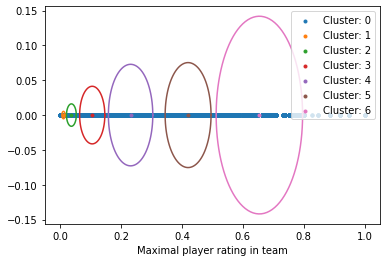

In [11]:
k = 7
pis, mus, sigmas = em(x_train[:, 0].reshape((-1, 1)), k)

In [12]:
def classify(point, pis, mus, sigmas, k):
    probabilites = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(point, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    return np.argmax(probabilites)

In [13]:
classify(0.9, pis, mus, sigmas, 7)

6

In [14]:
team_results_by_team_id_2020 = {}
for team_id, player_ids in team_player_ids_2020.items():
    team_player_ratings = []
    for i in range(len(player_ids)):
        if player_ids[i] in player_estimated_rating_increase_in_2020:
            team_player_ratings.append(player_estimated_rating_increase_in_2020[player_ids[i]])
    team_results_by_team_id_2020[team_id] = -np.sort(-np.array(team_player_ratings))

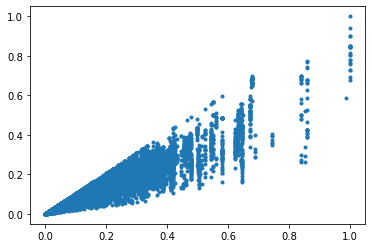

In [15]:
x_test = []
for team_result in team_results_by_team_id_2020.values():
    x_test.append([team_result[0], np.mean(team_result)])
x_test = normalize(np.array(x_test))
x_test_by_team_id = {}
keys = np.fromiter(team_results_by_team_id_2020.keys(), dtype=int)
for i in range(len(team_results_by_team_id_2020)):
    x_test_by_team_id[keys[i]] = x_test[i]
plt.scatter(x_test[:, 0], x_test[:, 1], marker='.')

In [16]:
def get_places_by_tournament_results(results):
    unique_results = -np.sort(-np.unique(results))
    place_by_result = {}
    for i in range(len(unique_results)):
        place_by_result[unique_results[i]] = i
    places = []
    for result in results:
        places.append(place_by_result[result])
    return places

In [17]:
total_corr_spear = 0
total_corr_ken = 0
num_corr_spear = 0
num_corr_ken = 0
num_nan_corr_spear = 0
num_nan_corr_ken = 0
for tournament_id, team_ids in team_ids_by_tournament_id_2020.items():
    team_results = np.array([percent_answered_by_team[team_id] for team_id in team_ids])
    team_results = get_places_by_tournament_results(team_results)
    predicted_team_results = np.array([classify(x_test_by_team_id[team_id][0], pis, mus, sigmas, 7) for team_id in team_ids])
    predicted_team_results = get_places_by_tournament_results(predicted_team_results)
    corr_spear = sp.stats.spearmanr(team_results, predicted_team_results)[0]
    if not math.isnan(corr_spear):
        total_corr_spear += corr_spear
        num_corr_spear += 1
    else:
        num_nan_corr_spear += 1
    corr_ken = sp.stats.kendalltau(team_results, predicted_team_results)[0]
    if not math.isnan(corr_ken):
        total_corr_ken += corr_ken
        num_corr_ken += 1
    else:
        num_nan_corr_ken += 1
print(f"Корреляция Спирмена, усредненная по всем турнирам: {total_corr_spear/num_corr_spear}")
print(f"(Не удалось посчитать корреляцию Спирмена для {num_nan_corr_spear} турниров из {num_corr_spear + num_nan_corr_spear})")
print(f"Корреляция Кендалла, усредненная по всем турнирам: {total_corr_ken/num_corr_ken}")
print(f"(Не удалось посчитать корреляцию Кендалла  для {num_nan_corr_ken} турниров из {num_corr_ken + num_nan_corr_ken})")

Корреляция Спирмена, усредненная по всем турнирам: 0.6334284555113786
(Не удалось посчитать корреляцию Спирмена для 1 турниров из 172)
Корреляция Кендалла, усредненная по всем турнирам: 0.5245729862170272
(Не удалось посчитать корреляцию Кендалла  для 1 турниров из 172)


### Рейтинг-лист турниров по сложности вопросов

In [30]:
tournament_complexity_by_name_sorted = {k: v for k, v in sorted(tournament_complexity_by_name.items(), key=lambda item: -item[1])}
print(tournament_complexity_by_name_sorted)

{'Дзержинский марафон': 7.438484934943289, 'Открытый Студенческий чемпионат Краснодарского края': 6.685185185185185, 'Молодёжный чемпионат Нижегородской области': 6.523232323232325, 'Чемпионат Санкт-Петербурга. Первая лига': 6.5, 'Кавалькада волхвов': 6.152341597796144, 'Первая лига ЧТ': 5.155555555555556, 'Студенческая лига ЧТ': 5.090058479532163, 'Высшая лига ЧТ': 3.9562841530054644, 'Чемпионат Санкт-Петербурга. Высшая лига': 3.611111111111111, 'Чемпионат Самары': 3.3125, 'БЛИК': 3.2999999999999994, 'Кубок Ростова': 3.125, 'Memel Cup': 3.090185185185185, 'Олимпийский Кубок Беларуси': 3.045121951219512, 'Зимние игры': 2.918560606060606, 'Чемпионат Екатеринбурга и Свердловской области': 2.8827416383219955, 'Поволжская лига': 2.7999999999999994, 'Кубок губернатора Иркутской области': 2.715151515151515, 'Открытый кубок Дальнего Востока (школьный зачёт)': 2.6288888888888886, 'U-Mind Games – студенты': 2.5806159420289854, 'Школьный синхрон-lite. Сезон 3': 2.5671957671957673, 'Июниор': 2.49

__Вывод:__ Оценка сложности турнира как произведение средней сложности вопросов из колонки questionQty таблицы tournaments на усредненный по всем вопросам процент правильных ответов - не очень хорошая оценка, т.к. школьные турниры распределены по всему рейтинг-листу при такой оценке. Хотя чемпионаты стран и городов, кажется, все же в большей степени расположились наверху рейтинга, что верно.